In [1]:
#imports from Mala

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches
%matplotlib inline
import json
import glob
import numpy as np
from PIL import Image
#import rasterio
#from scipy.misc import imsave
from imageio import imwrite
from sklearn.cluster import DBSCAN
Image.MAX_IMAGE_PIXELS = None

In [2]:
#To do: move these functions to .py files

def convert_coords(image, label, x, y): 
    
    ''' 
    convert from geographic coordinates to image-scaled coordinates, relative to bottom left of image
    '''

    # get coordinates defining extent of input image and labels
    x_min, y_min, x_max, y_max = label['bbox'][0], label['bbox'][1], label['bbox'][2], label['bbox'][3]
    
    # get distance of point x,y from image origin
    x_relative = x - x_min
    y_relative = y - y_min
        
    # get scaling factors
    width = x_max - x_min
    height = y_max - y_min
    (width_pix, height_pix) = image.size

    
    x_pix = x_relative/width * width_pix
    y_pix = y_relative/height * height_pix
    
    return x_pix, y_pix

In [3]:
def save_files(image, label, info):
    
    '''
    for each cluster of bounding boxes, save a 512x512 image chip as .png
    along with bounding box labels in YOLO format as .json
    '''
    
    # initialise a figure to visualise output tiles
    fig = plt.figure(figsize=(20, 100))
    n_tiles = len(info.keys())
    
    for i,k in enumerate(info.keys()):
                             
        # get centre of each bounding box cluster
        x, y = info[k]['centre'][0], info[k]['centre'][1] # in pixels, with origin in lower left
        
        # define coordinates for cropping
        # set limits since tile boundaries cannot exceed image boundaries
        width, height = image.getbbox()[2], image.getbbox()[3]

        left, top, right, bottom = x-256, (height-y)-256, x+256, (height-y)+256 # in accordance with PIL library: in pix, origin top left
               
        left_lim, top_lim = max(0,int(left)), max(0,int(top))
        right_lim, bottom_lim = min(width, int(right)), min(height, int(bottom))
               
        # crop and save image tiles
        image_name = 'dataset/{}_{}.png'.format(image_file[:-4], k)
        #image_str = file_path + '/' + image_name
        # it goes left-top-right-bottom where bottom=top+height (i.e. the origin is in the top left corner)
        image_tile = image.crop([left_lim, top_lim, right_lim, bottom_lim])
        imwrite(image_name, image_tile)

        ax = fig.add_subplot(n_tiles, 4, i+1)
        ax.imshow(image_tile)
                
        # save label file
        file = open(image_name.replace('.png', '.txt'), 'a')
        
        for j, box in enumerate(info[k]['object_boxes']):
            # get coordinates of lower left (x1) and upper right (x3) corner of bounding box
            [[x1, y1], [x3, y3]] = box # in px, origin in lower left
            
            # define bounding box coordinates relative to boundaries of current image tile
            x1_rel, x3_rel = x1-left_lim, x3-left_lim
            y1_rel, y3_rel = (height-y1)-top_lim, (height-y3)-top_lim
            
            # get some scaling factors to convert from image to tile coordinates
            tile_width = right_lim - left_lim
            tile_height = top_lim - bottom_lim

            # define bounding box centre & width
            box_centre_x = (x1_rel+x3_rel)//2
            box_centre_y = (y1_rel+y3_rel)//2
            box_width = x3-x1
            box_height = y1-y3
            
            # add bounding boxes to tile subplot
            rect = patches.Rectangle((x1_rel, y1_rel), box_width, box_height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            title = str(i+1)
            ax.set_title(title)

            # write label to .txt file
            ## 0 means first object i.e. whale
            ## (add a line here for multiple categoties - if info[k]['name'] = 'ship': lab = ...)
            
            #
            lab = '0 {} {} {} {}\n'.format(abs(box_centre_x/tile_width), abs(box_centre_y/tile_height), abs(box_width/tile_width), abs(box_height/tile_height))
            file.write(lab)
        file.close()
    plt.show()

In [25]:
#Data paths:

liebre1_image_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/liebrepansharp.tif"
liebre1_rgb_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/liebre1pansharpRGB.tif"
liebre1_points_shp_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/liebre_points_2015_image.shp"

In [26]:
#Change points shapefile to a geojson
import geopandas
#liebreshpfile = geopandas.read_file(liebre1_points_shp_path)
#liebreshpfile.to_file('/gws/nopw/j04/ai4er/users/kmgreen/data/liebre1_points.geojson', driver='GeoJSON')

In [27]:
liebre1_points_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/liebre1_points.geojson"

In [29]:
# visualise input image file + bounding boxes from label file
with open(liebre1_points_path, 'r') as f:
    label = json.load(f)
    image = Image.open(liebre1_image_path)
    # create figure
    fig1 = plt.figure(figsize=(16, 8))
    ax1 = fig1.add_subplot(111, aspect='equal')
    plt.imshow(np.flipud(image, origin='lower')) #  flip because imshow defines upper left as origin
    
    # plot bounding boxes
    for object in label['features']:
        
        # get origin and dimensions of each bounding box
        bottom_left_unconv = object['geometry']['coordinates'][0][0][0]
        top_right_unconv = object['geometry']['coordinates'][0][0][2]

        bottom_left = convert_coords(image, label, bottom_left_unconv[0], bottom_left_unconv[1])
        top_right = convert_coords(image, label, top_right_unconv[0], top_right_unconv[1])

        width = top_right[0] - bottom_left[0]
        height = top_right[1] - bottom_left[1]

        # add bounding box to figure
        rect = patches.Rectangle(bottom_left, width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)
        
    plt.show

UnidentifiedImageError: cannot identify image file '/gws/nopw/j04/ai4er/users/kmgreen/data/liebrepansharp.tif'

In [9]:
import rasterio

In [10]:
liebre_img = rasterio.open(liebre1_image_path)

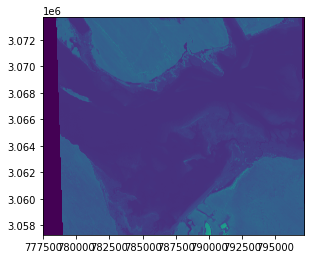

<AxesSubplot:>

In [11]:
from rasterio.plot import show
show(liebre_img)

<function matplotlib.pyplot.show(close=None, block=None)>

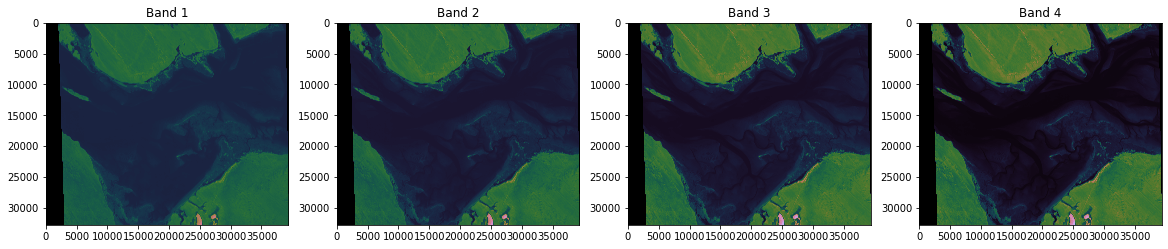

In [13]:
n_bands=liebre_img.count
fig = plt.figure(figsize=(20, 50))
for i in range(1,n_bands+1):
    ax = fig.add_subplot(n_bands, 4, i)
    ax.imshow(liebre_img.read(i),cmap='cubehelix')
    title = "Band " + str(i)
    ax.set_title(title)
plt.show

#shows 4 bands 